# EuroSAT Dataset Applying Custom CNN 

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: SeaLake --> count: 3000
class: HerbaceousVegetation --> count: 3000
class: Forest --> count: 3000
class: AnnualCrop --> count: 3000
class: Residential --> count: 3000
class: Highway --> count: 2500
class: Industrial --> count: 2500
class: PermanentCrop --> count: 2500
class: River --> count: 2500
class: Pasture --> count: 2000


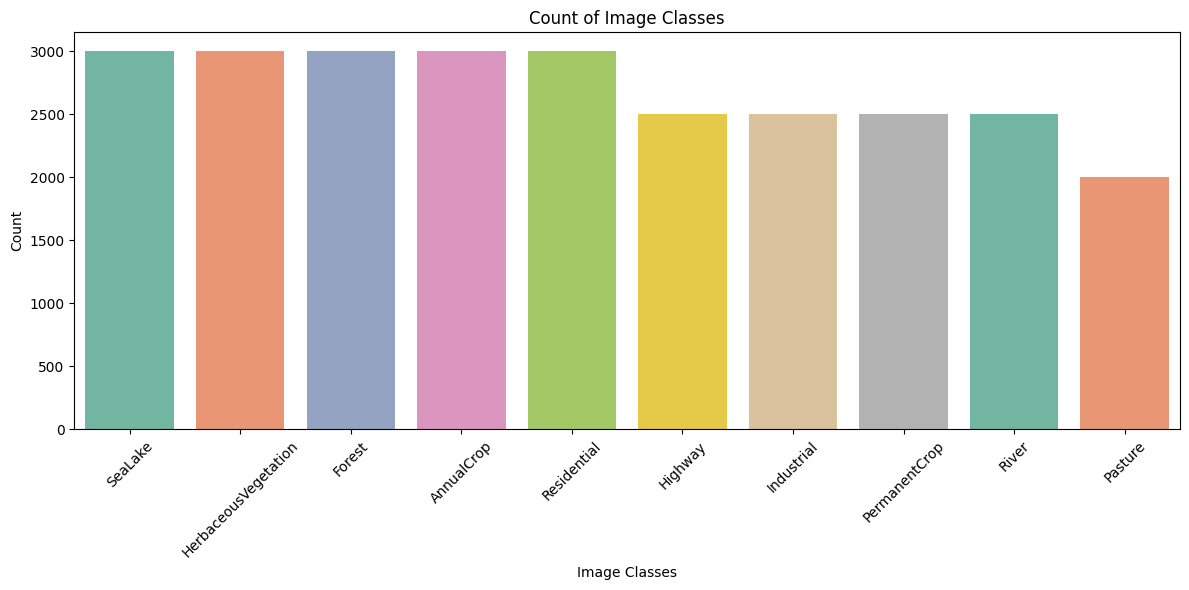

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

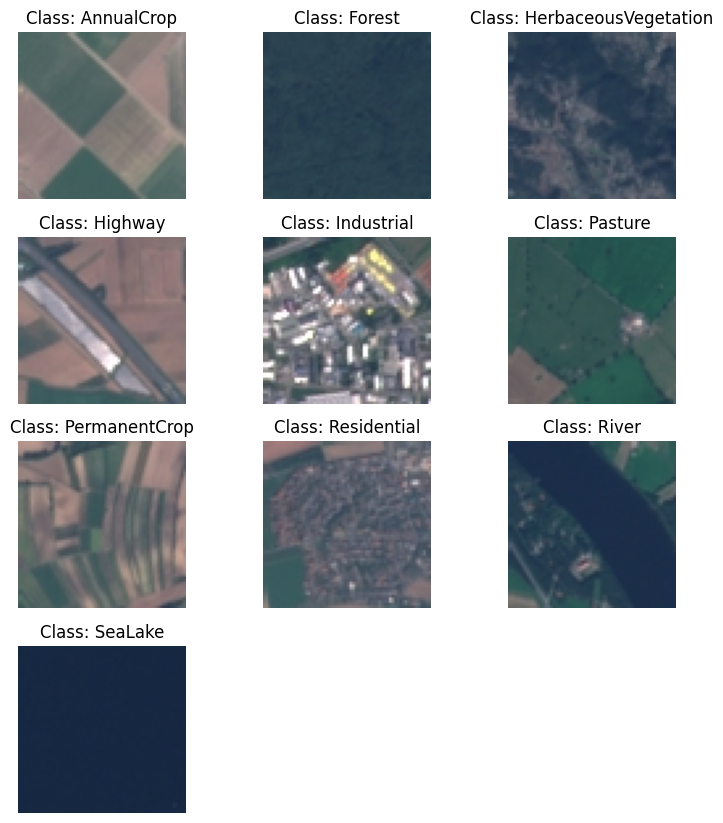

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Convolutional Neural Netwirk (G7CNN)

In [16]:

class Inception(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, pool_proj):
        super(Inception, self).__init__()
        
        # 1x1 conv
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1),
            nn.BatchNorm2d(out1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 3x3 conv
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.BatchNorm2d(red3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 5x5 conv (approximated with two 3x3 convs)
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.BatchNorm2d(red5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(red5x5, out5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(out5x5, out5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 pool -> 1x1 conv
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        return torch.cat([out1, out2, out3, out4], dim=1)


class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),  # 32x224x224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 5, padding=2),  # 64x112x112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1),  # 128x56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28
        )

        # Inception layer replaces this part of your conv block
        self.inception = Inception(
            in_channels=128,
            out1x1=32,
            red3x3=32, out3x3=64,
            red5x5=16, out5x5=16,
            pool_proj=16
        )  # Output: (32+64+16+16) = 128 channels

        self.final_conv_block = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256x28x28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512x14x14
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 7x7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),               # 512 * 7 * 7 = 25088
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)         # (B, 128, 28, 28)
        x = self.inception(x)          # (B, 128, 28, 28)
        x = self.final_conv_block(x)   # (B, 512, 7, 7)
        x = self.classifier(x)         # (B, num_classes)
        return x



In [17]:
total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          51,264
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           4,128
      BatchNorm2d-14           [-1, 32,

### Training

In [18]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=100, early_stop_patience=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/100: 100%|██████████| 296/296 [01:52<00:00,  2.64it/s, acc=0.567, loss=1.23]

Training Loss: 1.226 Acc: 0.567


Validation Loss: 0.716 Acc: 0.745
✅ Best model saved at epoch 1 with validation accuracy: 0.745


Epoch 2/100: 100%|██████████| 296/296 [00:49<00:00,  5.96it/s, acc=0.703, loss=0.868]

Training Loss: 0.868 Acc: 0.703


Validation Loss: 0.675 Acc: 0.763
✅ Best model saved at epoch 2 with validation accuracy: 0.763


Epoch 3/100: 100%|██████████| 296/296 [00:47<00:00,  6.18it/s, acc=0.747, loss=0.737]

Training Loss: 0.737 Acc: 0.747


Validation Loss: 0.732 Acc: 0.761


Epoch 4/100: 100%|██████████| 296/296 [00:50<00:00,  5.89it/s, acc=0.787, loss=0.634]

Training Loss: 0.634 Acc: 0.787


Validation Loss: 0.550 Acc: 0.825
✅ Best model saved at epoch 4 with validation accuracy: 0.825


Epoch 5/100: 100%|██████████| 296/296 [00:49<00:00,  5.95it/s, acc=0.82, loss=0.537] 

Training Loss: 0.537 Acc: 0.820


Validation Loss: 0.353 Acc: 0.881
✅ Best model saved at epoch 5 with validation accuracy: 0.881


Epoch 6/100: 100%|██████████| 296/296 [00:49<00:00,  6.01it/s, acc=0.841, loss=0.49] 

Training Loss: 0.490 Acc: 0.841


Validation Loss: 0.537 Acc: 0.819


Epoch 7/100: 100%|██████████| 296/296 [00:50<00:00,  5.89it/s, acc=0.857, loss=0.429]

Training Loss: 0.429 Acc: 0.857


Validation Loss: 0.283 Acc: 0.898
✅ Best model saved at epoch 7 with validation accuracy: 0.898


Epoch 8/100: 100%|██████████| 296/296 [00:48<00:00,  6.12it/s, acc=0.865, loss=0.409]

Training Loss: 0.409 Acc: 0.865


Validation Loss: 0.346 Acc: 0.884


Epoch 9/100: 100%|██████████| 296/296 [00:50<00:00,  5.82it/s, acc=0.88, loss=0.361] 

Training Loss: 0.361 Acc: 0.880


Validation Loss: 0.373 Acc: 0.878


Epoch 10/100: 100%|██████████| 296/296 [00:47<00:00,  6.17it/s, acc=0.889, loss=0.339]

Training Loss: 0.339 Acc: 0.889


Validation Loss: 0.531 Acc: 0.824


Epoch 11/100: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s, acc=0.895, loss=0.325]

Training Loss: 0.325 Acc: 0.895


Validation Loss: 0.457 Acc: 0.850


Epoch 12/100: 100%|██████████| 296/296 [00:49<00:00,  6.03it/s, acc=0.901, loss=0.311]

Training Loss: 0.311 Acc: 0.901


Validation Loss: 0.316 Acc: 0.896


Epoch 13/100: 100%|██████████| 296/296 [00:49<00:00,  5.93it/s, acc=0.903, loss=0.297]

Training Loss: 0.297 Acc: 0.903


Validation Loss: 0.320 Acc: 0.890


Epoch 14/100: 100%|██████████| 296/296 [00:47<00:00,  6.19it/s, acc=0.904, loss=0.285]

Training Loss: 0.285 Acc: 0.904


Validation Loss: 0.251 Acc: 0.908
✅ Best model saved at epoch 14 with validation accuracy: 0.908


Epoch 15/100: 100%|██████████| 296/296 [00:48<00:00,  6.12it/s, acc=0.912, loss=0.263]

Training Loss: 0.263 Acc: 0.912


Validation Loss: 0.194 Acc: 0.927
✅ Best model saved at epoch 15 with validation accuracy: 0.927


Epoch 16/100: 100%|██████████| 296/296 [00:47<00:00,  6.27it/s, acc=0.917, loss=0.253]

Training Loss: 0.253 Acc: 0.917


Validation Loss: 0.172 Acc: 0.942
✅ Best model saved at epoch 16 with validation accuracy: 0.942


Epoch 17/100: 100%|██████████| 296/296 [00:46<00:00,  6.36it/s, acc=0.913, loss=0.265]

Training Loss: 0.265 Acc: 0.913


Validation Loss: 0.361 Acc: 0.880


Epoch 18/100: 100%|██████████| 296/296 [00:48<00:00,  6.17it/s, acc=0.924, loss=0.235]

Training Loss: 0.235 Acc: 0.924


Validation Loss: 0.269 Acc: 0.920


Epoch 19/100: 100%|██████████| 296/296 [00:47<00:00,  6.20it/s, acc=0.923, loss=0.233]

Training Loss: 0.233 Acc: 0.923


Validation Loss: 0.190 Acc: 0.935


Epoch 20/100: 100%|██████████| 296/296 [00:48<00:00,  6.04it/s, acc=0.926, loss=0.231]

Training Loss: 0.231 Acc: 0.926


Validation Loss: 0.152 Acc: 0.947
✅ Best model saved at epoch 20 with validation accuracy: 0.947


Epoch 21/100: 100%|██████████| 296/296 [00:48<00:00,  6.12it/s, acc=0.928, loss=0.217]

Training Loss: 0.217 Acc: 0.928


Validation Loss: 0.237 Acc: 0.922


Epoch 22/100: 100%|██████████| 296/296 [00:49<00:00,  6.04it/s, acc=0.928, loss=0.223]

Training Loss: 0.223 Acc: 0.928


Validation Loss: 0.253 Acc: 0.920


Epoch 23/100: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s, acc=0.933, loss=0.2]  

Training Loss: 0.200 Acc: 0.933


Validation Loss: 0.141 Acc: 0.956
✅ Best model saved at epoch 23 with validation accuracy: 0.956


Epoch 24/100: 100%|██████████| 296/296 [00:47<00:00,  6.20it/s, acc=0.936, loss=0.19] 

Training Loss: 0.190 Acc: 0.936


Validation Loss: 0.158 Acc: 0.944


Epoch 25/100: 100%|██████████| 296/296 [00:49<00:00,  5.99it/s, acc=0.935, loss=0.196]

Training Loss: 0.196 Acc: 0.935


Validation Loss: 0.233 Acc: 0.919


Epoch 26/100: 100%|██████████| 296/296 [00:47<00:00,  6.22it/s, acc=0.935, loss=0.194]

Training Loss: 0.194 Acc: 0.935


Validation Loss: 0.252 Acc: 0.919


Epoch 27/100: 100%|██████████| 296/296 [00:48<00:00,  6.10it/s, acc=0.936, loss=0.189]

Training Loss: 0.189 Acc: 0.936


Validation Loss: 0.182 Acc: 0.942


Epoch 28/100: 100%|██████████| 296/296 [00:49<00:00,  6.02it/s, acc=0.94, loss=0.182] 

Training Loss: 0.182 Acc: 0.940


Validation Loss: 0.209 Acc: 0.937


Epoch 29/100: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s, acc=0.937, loss=0.185]

Training Loss: 0.185 Acc: 0.937


Validation Loss: 0.169 Acc: 0.947


Epoch 30/100: 100%|██████████| 296/296 [00:47<00:00,  6.26it/s, acc=0.94, loss=0.181] 

Training Loss: 0.181 Acc: 0.940


Validation Loss: 0.163 Acc: 0.942


Epoch 31/100: 100%|██████████| 296/296 [00:47<00:00,  6.18it/s, acc=0.946, loss=0.162]

Training Loss: 0.162 Acc: 0.946


Validation Loss: 0.146 Acc: 0.956
✅ Best model saved at epoch 31 with validation accuracy: 0.956


Epoch 32/100: 100%|██████████| 296/296 [00:50<00:00,  5.89it/s, acc=0.945, loss=0.166]

Training Loss: 0.166 Acc: 0.945


Validation Loss: 0.157 Acc: 0.954


Epoch 33/100: 100%|██████████| 296/296 [00:50<00:00,  5.92it/s, acc=0.944, loss=0.165]

Training Loss: 0.165 Acc: 0.944


Validation Loss: 0.245 Acc: 0.924


Epoch 34/100: 100%|██████████| 296/296 [00:48<00:00,  6.05it/s, acc=0.945, loss=0.165]

Training Loss: 0.165 Acc: 0.945


Validation Loss: 0.142 Acc: 0.956


Epoch 35/100: 100%|██████████| 296/296 [00:49<00:00,  5.93it/s, acc=0.946, loss=0.162]

Training Loss: 0.162 Acc: 0.946


Validation Loss: 0.177 Acc: 0.939


Epoch 36/100: 100%|██████████| 296/296 [00:49<00:00,  6.03it/s, acc=0.95, loss=0.15]  

Training Loss: 0.150 Acc: 0.950


Validation Loss: 0.130 Acc: 0.958
✅ Best model saved at epoch 36 with validation accuracy: 0.958


Epoch 37/100: 100%|██████████| 296/296 [00:46<00:00,  6.37it/s, acc=0.945, loss=0.162]

Training Loss: 0.162 Acc: 0.945


Validation Loss: 0.141 Acc: 0.954


Epoch 38/100: 100%|██████████| 296/296 [00:49<00:00,  5.99it/s, acc=0.949, loss=0.148]

Training Loss: 0.148 Acc: 0.949


Validation Loss: 0.135 Acc: 0.962
✅ Best model saved at epoch 38 with validation accuracy: 0.962


Epoch 39/100: 100%|██████████| 296/296 [00:47<00:00,  6.26it/s, acc=0.951, loss=0.146]

Training Loss: 0.146 Acc: 0.951


Validation Loss: 0.137 Acc: 0.959


Epoch 40/100: 100%|██████████| 296/296 [00:48<00:00,  6.16it/s, acc=0.95, loss=0.144] 

Training Loss: 0.144 Acc: 0.950


Validation Loss: 0.167 Acc: 0.949


Epoch 41/100: 100%|██████████| 296/296 [00:47<00:00,  6.23it/s, acc=0.951, loss=0.144]

Training Loss: 0.144 Acc: 0.951


Validation Loss: 0.122 Acc: 0.961


Epoch 42/100: 100%|██████████| 296/296 [00:47<00:00,  6.19it/s, acc=0.954, loss=0.137]

Training Loss: 0.137 Acc: 0.954


Validation Loss: 0.136 Acc: 0.960


Epoch 43/100: 100%|██████████| 296/296 [00:47<00:00,  6.21it/s, acc=0.953, loss=0.139]

Training Loss: 0.139 Acc: 0.953


Validation Loss: 0.145 Acc: 0.958


Epoch 44/100: 100%|██████████| 296/296 [00:47<00:00,  6.24it/s, acc=0.955, loss=0.138]

Training Loss: 0.138 Acc: 0.955


Validation Loss: 0.122 Acc: 0.963
✅ Best model saved at epoch 44 with validation accuracy: 0.963


Epoch 45/100: 100%|██████████| 296/296 [00:47<00:00,  6.19it/s, acc=0.957, loss=0.126]

Training Loss: 0.126 Acc: 0.957


Validation Loss: 0.122 Acc: 0.968
✅ Best model saved at epoch 45 with validation accuracy: 0.968


Epoch 46/100: 100%|██████████| 296/296 [00:47<00:00,  6.27it/s, acc=0.957, loss=0.13] 

Training Loss: 0.130 Acc: 0.957


Validation Loss: 0.131 Acc: 0.958


Epoch 47/100: 100%|██████████| 296/296 [00:49<00:00,  6.03it/s, acc=0.955, loss=0.134]

Training Loss: 0.134 Acc: 0.955


Validation Loss: 0.942 Acc: 0.764


Epoch 48/100: 100%|██████████| 296/296 [00:46<00:00,  6.33it/s, acc=0.956, loss=0.126]

Training Loss: 0.126 Acc: 0.956


Validation Loss: 0.187 Acc: 0.945


Epoch 49/100: 100%|██████████| 296/296 [00:46<00:00,  6.35it/s, acc=0.958, loss=0.124]

Training Loss: 0.124 Acc: 0.958


Validation Loss: 0.147 Acc: 0.959


Epoch 50/100: 100%|██████████| 296/296 [00:48<00:00,  6.11it/s, acc=0.959, loss=0.123]

Training Loss: 0.123 Acc: 0.959


Validation Loss: 0.134 Acc: 0.961


Epoch 51/100: 100%|██████████| 296/296 [00:47<00:00,  6.25it/s, acc=0.961, loss=0.116]

Training Loss: 0.116 Acc: 0.961


Validation Loss: 0.118 Acc: 0.964


Epoch 52/100: 100%|██████████| 296/296 [00:47<00:00,  6.23it/s, acc=0.96, loss=0.12]  

Training Loss: 0.120 Acc: 0.960


Validation Loss: 0.139 Acc: 0.958


Epoch 53/100: 100%|██████████| 296/296 [00:48<00:00,  6.05it/s, acc=0.962, loss=0.115]

Training Loss: 0.115 Acc: 0.962


Validation Loss: 0.105 Acc: 0.968


Epoch 54/100: 100%|██████████| 296/296 [00:47<00:00,  6.26it/s, acc=0.96, loss=0.116] 

Training Loss: 0.116 Acc: 0.960


Validation Loss: 0.214 Acc: 0.936


Epoch 55/100: 100%|██████████| 296/296 [00:48<00:00,  6.17it/s, acc=0.959, loss=0.122]

Training Loss: 0.122 Acc: 0.959


Validation Loss: 0.105 Acc: 0.964


Epoch 56/100: 100%|██████████| 296/296 [00:47<00:00,  6.19it/s, acc=0.96, loss=0.113] 

Training Loss: 0.113 Acc: 0.960


Validation Loss: 0.146 Acc: 0.958


Epoch 57/100: 100%|██████████| 296/296 [00:47<00:00,  6.20it/s, acc=0.962, loss=0.112]

Training Loss: 0.112 Acc: 0.962


Validation Loss: 0.130 Acc: 0.962


Epoch 58/100: 100%|██████████| 296/296 [00:48<00:00,  6.16it/s, acc=0.962, loss=0.11] 

Training Loss: 0.110 Acc: 0.962


Validation Loss: 0.117 Acc: 0.965


Epoch 59/100: 100%|██████████| 296/296 [00:48<00:00,  6.11it/s, acc=0.964, loss=0.107]

Training Loss: 0.107 Acc: 0.964


Validation Loss: 0.116 Acc: 0.964


Epoch 60/100: 100%|██████████| 296/296 [00:48<00:00,  6.14it/s, acc=0.964, loss=0.106]

Training Loss: 0.106 Acc: 0.964


Validation Loss: 0.231 Acc: 0.935


Epoch 61/100: 100%|██████████| 296/296 [00:48<00:00,  6.10it/s, acc=0.961, loss=0.11] 

Training Loss: 0.110 Acc: 0.961


Validation Loss: 0.136 Acc: 0.964


Epoch 62/100: 100%|██████████| 296/296 [00:47<00:00,  6.23it/s, acc=0.963, loss=0.108]

Training Loss: 0.108 Acc: 0.963


Validation Loss: 0.123 Acc: 0.965


Epoch 63/100: 100%|██████████| 296/296 [00:47<00:00,  6.29it/s, acc=0.963, loss=0.106] 

Training Loss: 0.106 Acc: 0.963


Validation Loss: 0.150 Acc: 0.958


Epoch 64/100: 100%|██████████| 296/296 [00:48<00:00,  6.10it/s, acc=0.967, loss=0.0989]

Training Loss: 0.099 Acc: 0.967


Validation Loss: 0.090 Acc: 0.971
✅ Best model saved at epoch 64 with validation accuracy: 0.971


Epoch 65/100: 100%|██████████| 296/296 [00:47<00:00,  6.22it/s, acc=0.966, loss=0.0976]

Training Loss: 0.098 Acc: 0.966


Validation Loss: 0.143 Acc: 0.958


Epoch 66/100: 100%|██████████| 296/296 [00:48<00:00,  6.13it/s, acc=0.967, loss=0.0999]

Training Loss: 0.100 Acc: 0.967


Validation Loss: 0.118 Acc: 0.963


Epoch 67/100: 100%|██████████| 296/296 [00:48<00:00,  6.09it/s, acc=0.968, loss=0.0942]

Training Loss: 0.094 Acc: 0.968


Validation Loss: 0.099 Acc: 0.972
✅ Best model saved at epoch 67 with validation accuracy: 0.972


Epoch 68/100: 100%|██████████| 296/296 [00:48<00:00,  6.13it/s, acc=0.966, loss=0.102] 

Training Loss: 0.102 Acc: 0.966


Validation Loss: 0.133 Acc: 0.959


Epoch 69/100: 100%|██████████| 296/296 [00:47<00:00,  6.23it/s, acc=0.967, loss=0.0965]

Training Loss: 0.097 Acc: 0.967


Validation Loss: 0.142 Acc: 0.963


Epoch 70/100: 100%|██████████| 296/296 [00:47<00:00,  6.20it/s, acc=0.97, loss=0.0915] 

Training Loss: 0.092 Acc: 0.970


Validation Loss: 0.117 Acc: 0.961


Epoch 71/100: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s, acc=0.969, loss=0.0885]

Training Loss: 0.089 Acc: 0.969


Validation Loss: 0.130 Acc: 0.959


Epoch 72/100: 100%|██████████| 296/296 [00:47<00:00,  6.18it/s, acc=0.966, loss=0.0984]

Training Loss: 0.098 Acc: 0.966


Validation Loss: 0.098 Acc: 0.969


Epoch 73/100: 100%|██████████| 296/296 [00:48<00:00,  6.13it/s, acc=0.97, loss=0.0875] 

Training Loss: 0.087 Acc: 0.970


Validation Loss: 0.147 Acc: 0.959


Epoch 74/100: 100%|██████████| 296/296 [00:48<00:00,  6.11it/s, acc=0.969, loss=0.0927]

Training Loss: 0.093 Acc: 0.969


Validation Loss: 0.104 Acc: 0.969


Epoch 75/100: 100%|██████████| 296/296 [00:48<00:00,  6.15it/s, acc=0.972, loss=0.0831]

Training Loss: 0.083 Acc: 0.972


Validation Loss: 0.096 Acc: 0.974
✅ Best model saved at epoch 75 with validation accuracy: 0.974


Epoch 76/100: 100%|██████████| 296/296 [00:47<00:00,  6.21it/s, acc=0.969, loss=0.0928]

Training Loss: 0.093 Acc: 0.969


Validation Loss: 0.108 Acc: 0.971


Epoch 77/100: 100%|██████████| 296/296 [00:48<00:00,  6.08it/s, acc=0.969, loss=0.088] 

Training Loss: 0.088 Acc: 0.969


Validation Loss: 0.189 Acc: 0.947


Epoch 78/100: 100%|██████████| 296/296 [00:47<00:00,  6.24it/s, acc=0.969, loss=0.0908]

Training Loss: 0.091 Acc: 0.969


Validation Loss: 0.098 Acc: 0.973


Epoch 79/100: 100%|██████████| 296/296 [00:53<00:00,  5.51it/s, acc=0.971, loss=0.0855]

Training Loss: 0.086 Acc: 0.971


Validation Loss: 0.156 Acc: 0.953


Epoch 80/100: 100%|██████████| 296/296 [00:54<00:00,  5.46it/s, acc=0.971, loss=0.0862]

Training Loss: 0.086 Acc: 0.971


Validation Loss: 0.162 Acc: 0.954


Epoch 81/100: 100%|██████████| 296/296 [00:49<00:00,  5.92it/s, acc=0.971, loss=0.0873]

Training Loss: 0.087 Acc: 0.971


Validation Loss: 0.125 Acc: 0.964


Epoch 82/100: 100%|██████████| 296/296 [00:49<00:00,  6.03it/s, acc=0.972, loss=0.0855]

Training Loss: 0.085 Acc: 0.972


Validation Loss: 0.095 Acc: 0.972


Epoch 83/100: 100%|██████████| 296/296 [00:48<00:00,  6.14it/s, acc=0.971, loss=0.0875]

Training Loss: 0.088 Acc: 0.971


Validation Loss: 0.150 Acc: 0.957


Epoch 84/100: 100%|██████████| 296/296 [00:48<00:00,  6.15it/s, acc=0.974, loss=0.0791]

Training Loss: 0.079 Acc: 0.974


Validation Loss: 0.158 Acc: 0.961


Epoch 85/100: 100%|██████████| 296/296 [00:49<00:00,  5.95it/s, acc=0.975, loss=0.0762]

Training Loss: 0.076 Acc: 0.975


Validation Loss: 0.093 Acc: 0.972


Epoch 86/100: 100%|██████████| 296/296 [00:48<00:00,  6.06it/s, acc=0.972, loss=0.0807]

Training Loss: 0.081 Acc: 0.972


Validation Loss: 0.102 Acc: 0.970


Epoch 87/100: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s, acc=0.971, loss=0.0837]

Training Loss: 0.084 Acc: 0.971


Validation Loss: 0.087 Acc: 0.977
✅ Best model saved at epoch 87 with validation accuracy: 0.977


Epoch 88/100: 100%|██████████| 296/296 [00:50<00:00,  5.82it/s, acc=0.975, loss=0.0731]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.166 Acc: 0.958


Epoch 89/100: 100%|██████████| 296/296 [00:50<00:00,  5.85it/s, acc=0.974, loss=0.0746]

Training Loss: 0.075 Acc: 0.974


Validation Loss: 0.103 Acc: 0.972


Epoch 90/100: 100%|██████████| 296/296 [00:50<00:00,  5.85it/s, acc=0.974, loss=0.0735]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.120 Acc: 0.969


Epoch 91/100: 100%|██████████| 296/296 [00:50<00:00,  5.88it/s, acc=0.973, loss=0.0768]

Training Loss: 0.077 Acc: 0.973


Validation Loss: 0.112 Acc: 0.971


Epoch 92/100: 100%|██████████| 296/296 [00:50<00:00,  5.88it/s, acc=0.975, loss=0.0731]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.123 Acc: 0.971


Epoch 93/100: 100%|██████████| 296/296 [00:48<00:00,  6.07it/s, acc=0.973, loss=0.0807]

Training Loss: 0.081 Acc: 0.973


Validation Loss: 0.095 Acc: 0.975


Epoch 94/100: 100%|██████████| 296/296 [00:50<00:00,  5.88it/s, acc=0.975, loss=0.0725]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.139 Acc: 0.961


Epoch 95/100: 100%|██████████| 296/296 [00:49<00:00,  5.95it/s, acc=0.974, loss=0.0746]

Training Loss: 0.075 Acc: 0.974


Validation Loss: 0.104 Acc: 0.967


Epoch 96/100: 100%|██████████| 296/296 [00:49<00:00,  5.96it/s, acc=0.978, loss=0.0634]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.120 Acc: 0.970


Epoch 97/100: 100%|██████████| 296/296 [00:50<00:00,  5.83it/s, acc=0.975, loss=0.0729]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.103 Acc: 0.974


Epoch 98/100: 100%|██████████| 296/296 [00:49<00:00,  5.94it/s, acc=0.975, loss=0.0787]

Training Loss: 0.079 Acc: 0.975


Validation Loss: 0.112 Acc: 0.972


Epoch 99/100: 100%|██████████| 296/296 [00:50<00:00,  5.90it/s, acc=0.976, loss=0.0717]

Training Loss: 0.072 Acc: 0.976


Validation Loss: 0.155 Acc: 0.964


Epoch 100/100: 100%|██████████| 296/296 [00:49<00:00,  5.94it/s, acc=0.976, loss=0.0756]

Training Loss: 0.076 Acc: 0.976


Validation Loss: 0.096 Acc: 0.977
Training Time: 5548.58 seconds ---> 92.48 minutes


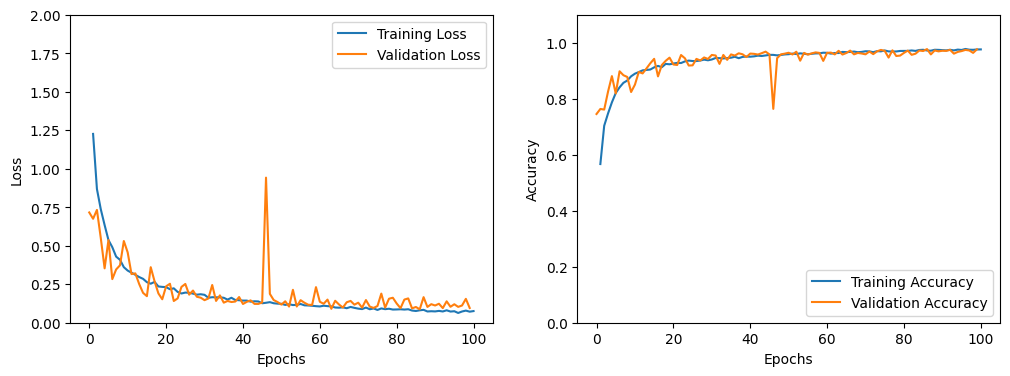

In [19]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [20]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 87) - Validation Loss: 0.092, Validation Accuracy: 0.976


In [21]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.974
Test Time: 17.65 seconds ---> 0.29 minutes


In [22]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       450
           1       0.99      0.98      0.98       450
           2       0.96      0.96      0.96       450
           3       0.97      0.98      0.98       375
           4       1.00      0.98      0.99       375
           5       0.95      0.93      0.94       300
           6       0.95      0.97      0.96       375
           7       0.99      1.00      1.00       450
           8       0.98      0.96      0.97       375
           9       0.99      0.99      0.99       450

    accuracy                           0.97      4050
   macro avg       0.97      0.97      0.97      4050
weighted avg       0.97      0.97      0.97      4050

Class 0 Accuracy: 0.976
Class 1 Accuracy: 0.978
Class 2 Accuracy: 0.951
Class 3 Accuracy: 0.979
Class 4 Accuracy: 0.979
Class 5 Accuracy: 0.930
Class 6 Accuracy: 0.965
Class 7 Accuracy: 1.000
Class 8 Accuracy: 0.963
Cl

### Confusion Matrix

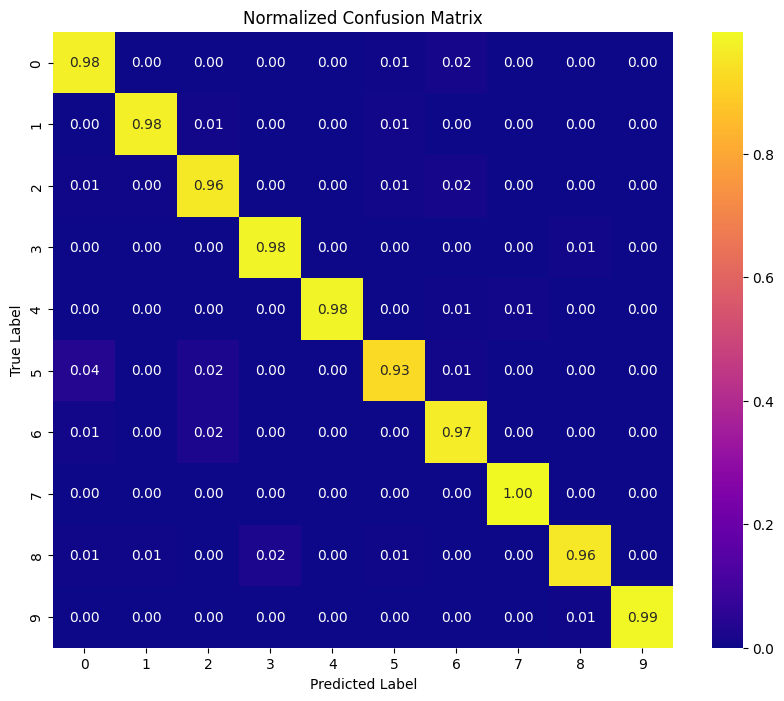

In [23]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

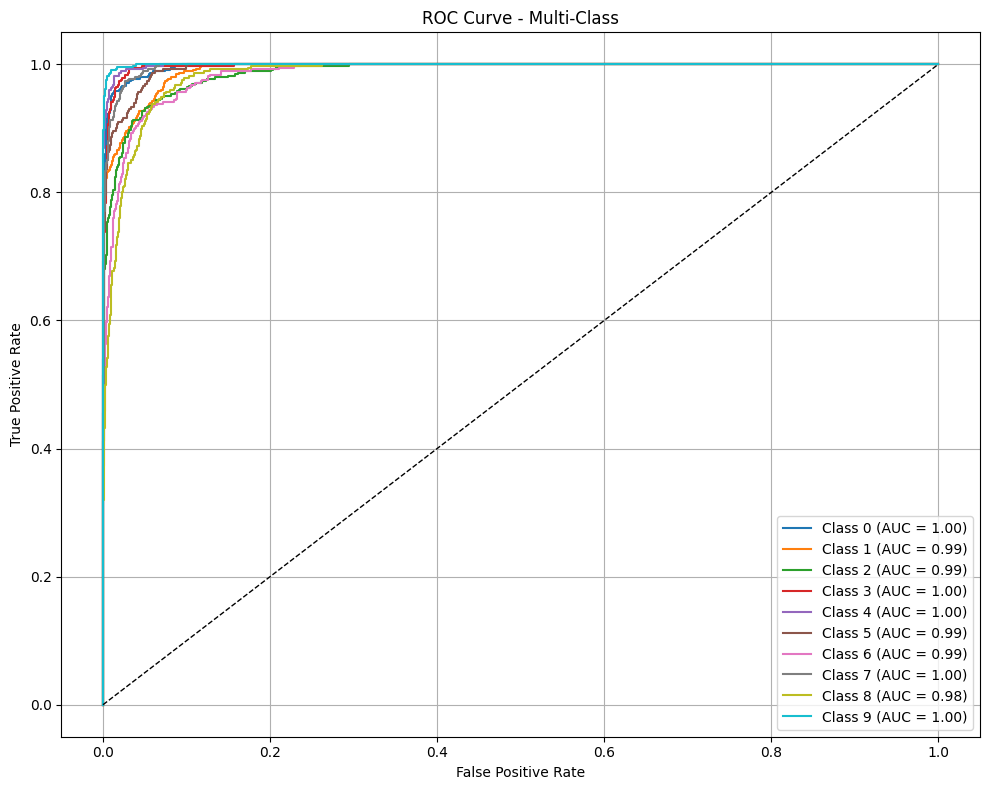

In [24]:
# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(total_class)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()